## Authors
Baptiste PREVOT (baptiste.prevot)

Gabriel BARDINET (gabriel.bardinet)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D, Rescaling
from keras.optimizers import Adam
from keras.regularizers import l2 
from tensorflow.keras.optimizers import AdamW

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
import shutil
from keras.optimizers import SGD

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!tar xzf /kaggle/input/navires-2024-fait-main/ships24.tgz

!ls /kaggle/working 

#Hyper Parameters


# Exemple d'utilisation avec un dossier "images" contenant les sous-dossiers et les images
root_directory = "/kaggle/working/ships_gray"


2024-06-02 20:31:18.995708: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 20:31:18.995878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 20:31:19.236216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/navires-2024-fait-main/ships24.tgz
__notebook__.ipynb  ships_gray	test.npy


## Hyper Parameters

In [2]:
IMG_WIDTH = 192
IMG_HEIGHT = 128
IMG_DIM2 = (IMG_HEIGHT, IMG_WIDTH)
IMG_DIM3 = (IMG_HEIGHT, IMG_WIDTH, 1)
N_CLASSES = 10
BATCH_SIZE = 64
VALIDATION_SIZE = 0.2

## A way to do data augmentation by hand. It's slower to create but the results are more convincing.

In [3]:

import os
from PIL import Image

def rotate_images_in_subdirectories(root_directory):
    # Parcours des sous-dossiers
    print("rotate")
    for subdir in os.listdir(root_directory):
        subdir_path = os.path.join(root_directory, subdir)
        if os.path.isdir(subdir_path):
            # Parcours des fichiers dans le sous-dossier
            for filename in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, filename)
                # Vérification que le fichier est une image
                if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                    # Ouverture de l'image
                    with Image.open(file_path) as img:
                        rotated_img_h = img.transpose(Image.FLIP_LEFT_RIGHT)
                        rotated_img_h.save(os.path.join(subdir_path, f"horizontal_{filename}"))
                        rotated_img_v = img.transpose(Image.FLIP_TOP_BOTTOM)
                        rotated_img_v.save(os.path.join(subdir_path, f"vertical_{filename}"))


In [4]:
import os
import tensorflow as tf
val_set = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/ships_gray',
    validation_split=0.2,
    subset="validation",
    color_mode = 'grayscale',
    seed=123,
    image_size=IMG_DIM2,
    batch_size=BATCH_SIZE
)
val_batches = tf.data.experimental.cardinality(val_set)
test_set = val_set.take((2*val_batches) // 3)
val_set = val_set.skip((2*val_batches) // 3)

rotate_images_in_subdirectories(root_directory)

training_set = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/working/ships_gray',
    validation_split=0.2,
    subset="training",
    color_mode = 'grayscale',
    seed=123,
    image_size=IMG_DIM2,
    batch_size=BATCH_SIZE
)

Found 42204 files belonging to 10 classes.
Using 8440 files for validation.
rotate
Found 126612 files belonging to 10 classes.
Using 101290 files for training.


In [5]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [6]:
def define_model():
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=IMG_DIM3))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=IMG_DIM3))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(N_CLASSES, activation='softmax'))
    # compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

**Load Dataset**

## Choose between loading an existing model or creating a new one

In [7]:
try:
    model = tf.keras.models.load_model('/kaggle/working/best_model.keras')
except:
    model = define_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## Training the model

In [8]:
history = model.fit(training_set, epochs=1, validation_data=val_set,
                       verbose=1,
                       batch_size=BATCH_SIZE,
                       callbacks=[reduce_lr, early_stopping, checkpoint])

I0000 00:00:1717360395.961460      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717360395.990454      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1583/1583 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5155 - loss: 1.4617

W0000 00:00:1717360637.167634      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717360639.131957      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.66026, saving model to best_model.keras


W0000 00:00:1717360651.013669      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1583/1583 ━━━━━━━━━━━━━━━━━━━━ 301s 161ms/step - accuracy: 0.5156 - loss: 1.4614 - val_accuracy: 0.6603 - val_loss: 1.0110 - learning_rate: 0.0010


## Performance and results evaluation

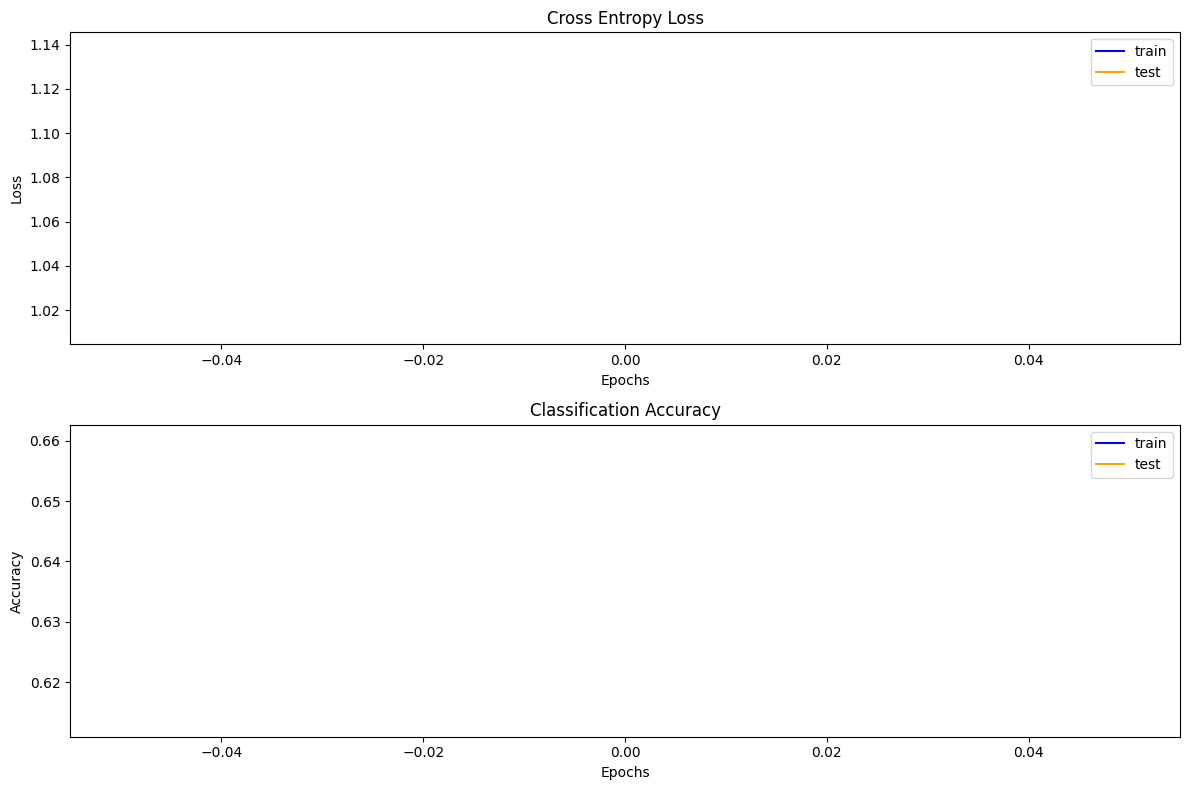

176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
Test Accuracy: 0.6857


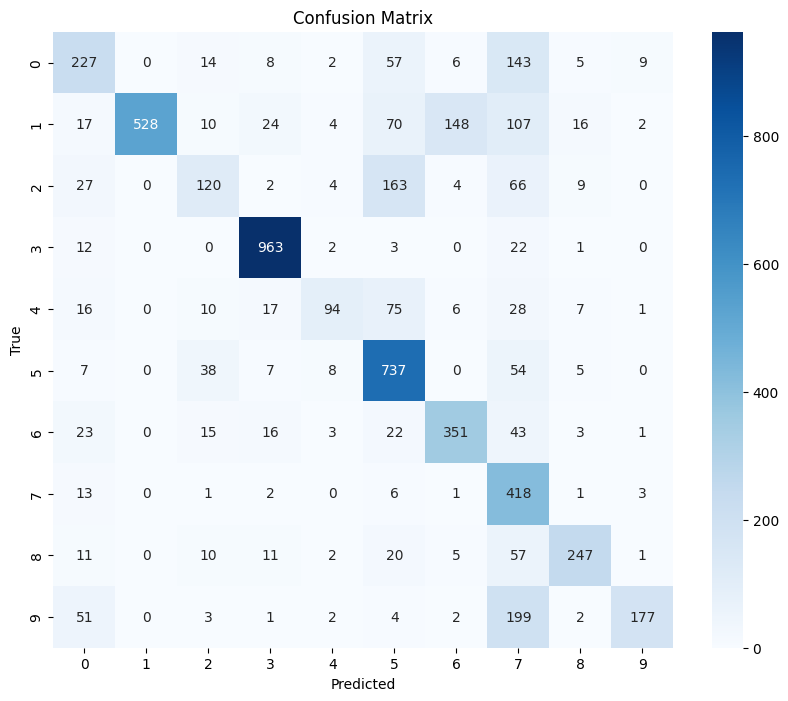

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.48      0.52       471
           1       1.00      0.57      0.73       926
           2       0.54      0.30      0.39       395
           3       0.92      0.96      0.94      1003
           4       0.78      0.37      0.50       254
           5       0.64      0.86      0.73       856
           6       0.67      0.74      0.70       477
           7       0.37      0.94      0.53       445
           8       0.83      0.68      0.75       364
           9       0.91      0.40      0.56       441

    accuracy                           0.69      5632
   macro avg       0.72      0.63      0.63      5632
weighted avg       0.76      0.69      0.68      5632



In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def summarize_diagnostics(history, model, X_test, y_test):
    # Plot loss
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Model performance score
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = y_test

    test_accuracy = accuracy_score(y_true, y_pred)
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Classification Report
    print('Classification Report:')
    print(classification_report(y_true, y_pred))
    
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)
try:
    X_test, y_test = dataset_to_numpy(test_set)
    summarize_diagnostics(history, model, X_test, y_test)
except:
    summarize_diagnostics(history, model, X_test, y_test)

In [10]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  29


## Prediction on the given test to be submitted

In [11]:
from keras.preprocessing.image import img_to_array, array_to_img

test_set = np.load('/kaggle/working/test.npy', allow_pickle=True)

test_set = test_set.reshape(test_set.shape[0], test_set.shape[1], test_set.shape[2], 1)
res = model.predict(test_set).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="ID")
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')
!head reco_nav.csv

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step


W0000 00:00:1717360675.721546      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


ID,Category
0,5
1,5
2,5
3,3
4,7
5,8
6,2
7,5
8,7
